# Extended Kalman Filter Demo

* $X_t = A X_{t-1} + BU_t + Q$
* $Z_t = C X_t + R$

<img src="images/robot-mobile-pioneer-3-at.jpg" alt="Trial Image" width="300" style="float: right"/>  
   * Consider a simple planar outdoor robot with Wheel Encoders & GNSS Receiver
   * Let's say that the forward velocity and angular velocity are the control inputs
   * In other words the robot dynamics are modelled as unicycle
   * Simulation Frequency = model dynamics frequency = 100 Hz (0.01s)
   * GPS Frequency = Measurement Update = 20 Hz (0.05s)
   * State Vector $X_t$ = $\begin{pmatrix}
       x_t \\
       y_t \\
       \theta_t \\
       v_t
     \end{pmatrix}$
   * Input Vector $U_t$ = $\begin{pmatrix}
   v_t \\
   \omega_t
   \end{pmatrix}$
   * Measurement vector $Z_t$ = $\begin{pmatrix}
   x_t \\
   y_t
   \end{pmatrix}$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import time

In [2]:
# Sim params
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5,0.5]) ** 2
DT = 0.1

### System Dynamics
* $x_t = x_{t-1} + v_t \cos(\theta_t) $
* $y_t = y_{t-1} + v_t \sin(\theta_t) $
* $\theta_t = \theta_{t-1} + \omega_t \times dt$
* For $X_t = A X_{t-1} + B U_t$:
    - $ A = \begin{bmatrix} 
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0
       \end{bmatrix}$
    - $ B = \begin{bmatrix}
        \cos(\theta_t) & 0 \\
        \sin(\theta_t) & 0 \\
        0 & dt \\
        1 & 0
        \end{bmatrix} $
    - $ J_{A} = \begin{bmatrix}
        \frac{dx_t}{dx_{t}} & \frac{dx_t}{dy_t} & \frac{dx_t}{d\theta_t} & \frac{dx_t}{dv_t} \\
        \frac{dy_t}{dx_{t}} & \frac{dy_t}{dy_t} & \frac{dy_t}{d\theta_t} & \frac{dy_t}{dv_t}  \\\frac{d\theta_t}{dx_{t}} & \frac{d\theta_t}{dy_t} & \frac{d\theta_t}{d\theta_t} & \frac{d\theta_t}{dv_t}  \\
        \frac{dv_t}{dx_{t}} & \frac{dv_t}{dy_t} & \frac{dv_t}{d\theta_t} & \frac{dv_t}{dv_t} 
        \end{bmatrix} $
    - $ J_{A} = \begin{bmatrix}
    1 & 0 & -v dt \sin(\theta) & \cos(\theta)dt \\
    0 & 1 & v dt \cos(\theta) & \sin(\theta)dt \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
    \end{bmatrix} $

In [3]:
def motion_model(x, u):
    A = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = A @ x + B @ u

    return x

In [4]:
def compute_JA(x, u):
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

In [5]:
def get_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    rot = np.array([[math.cos(angle), math.sin(angle)],
                    [-math.sin(angle), math.cos(angle)]])
    fx = rot @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0])
    py = np.array(fx[1, :] + xEst[1, 0])
    return px, py

In [6]:
def prediction(xd, u, P):
    jA = compute_JA(xd, u)
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)
    xd = motion_model(xd, ud)
    P_est = jA @ P @ jA.T + Q
    return xd,P_est

In [7]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

In [8]:
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance

In [9]:
%matplotlib notebook

In [10]:
# Simulate
t = 0.0
SIM_TIME = 30.0

# State Vector [x y yaw v]'
xTrue = np.zeros((4, 1))
PEst = 0.0001 * np.eye(4)
xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxTrue = xTrue
hxDR = xTrue
temp = np.arange(0, 2 * math.pi + 0.1, 0.1)
allellipsesX = np.zeros((1, temp.size))
allellipsesY = np.zeros((1, temp.size))

while SIM_TIME >= t:
    t += DT
    u = calc_input()
    # Propagate
    xTrue = motion_model(xTrue, u)
    xDR, PEst = prediction(xDR, u, PEst)
    
    # Get Covariance Ellipse
    ellipsesX, ellipsesY = get_covariance_ellipse(xDR, PEst)
    
    # Stack the history
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    allellipsesX = np.vstack((allellipsesX, ellipsesX))
    allellipsesY = np.vstack((allellipsesY, ellipsesY))

<IPython.core.display.Javascript object>


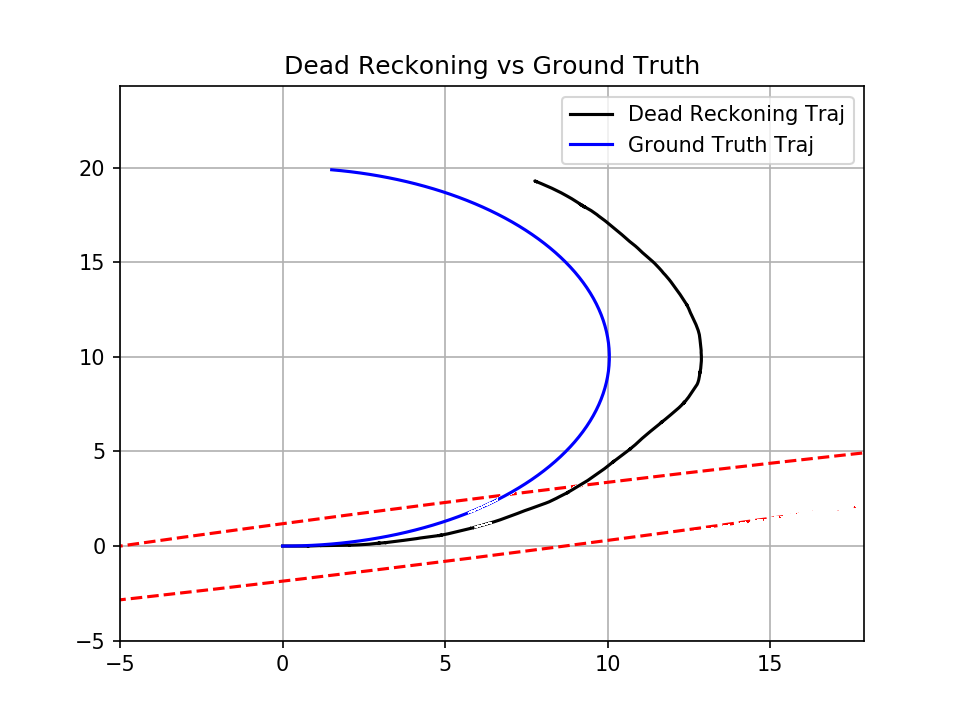

In [11]:
# Animate DR
fig, ax = plt.subplots()
drData, = plt.plot([],[],'-k', label='Dead Reckoning Traj')
ellipseData, = plt.plot([],[],'--r')
gtData, = plt.plot([],[],'-b', label='Ground Truth Traj')
numFrames = 1000

frames=np.linspace(0, numFrames)
ind = [(int)(frame * allellipsesX.shape[0]/ numFrames) for frame in frames]

def init():
    x_dr = hxDR[0,:]
    y_dr = hxDR[1,:]
    ax.set_xlim([np.min(x_dr) - 5, np.max(x_dr) + 5])
    ax.set_ylim([np.min(y_dr) - 5, np.max(y_dr) + 5])
    plt.title("Dead Reckoning vs Ground Truth")
    plt.legend()
    ax.grid(True)
    
def update(frameID):
    drData.set_data(hxDR[0,0:ind[frameID]], hxDR[1,0:ind[frameID]])
    gtData.set_data(hxTrue[0,0:ind[frameID]], hxTrue[1,0:ind[frameID]])
    ellipseData.set_data(allellipsesX[ind[frameID],:],allellipsesY[ind[frameID],:])

anim = FuncAnimation(fig, update, frames=numFrames, init_func=init, blit=True)
plt.show()

### Adding GPS as a measurement source
$Z_t = H X_t + R$

$H = J_H = \begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}$

In [12]:
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

In [13]:
def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z

In [14]:
def compute_jH():
    jH = np.array([[1.0,0.0,0.0,0.0],
                   [0.0,1.0,0.0,0.0]])
    return jH

In [15]:
def ekf_update(xTrue, xPred, PPred):
    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)
    
    # Computed the difference between measurement and predicted measurement
    zPred = observation_model(xPred)
    y = z - zPred
    
    # Compute Kalman Gain and find new belief
    jH = compute_jH()
    S = jH @ PPred @ jH.T + R
    K = PPred @ jH.T @ np.linalg.inv(S)
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jH) @ PPred
    return xEst, PEst, z.T

In [16]:
# Simulate - EKF
t = 0.0
SIM_TIME = 50.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)
PPred = np.eye(4)
PDR = np.eye(4)
xDR = np.zeros((4, 1)) 
xPred = np.zeros((4,1))

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue

temp = np.arange(0, 2 * math.pi + 0.1, 0.1)
allellipsesX = np.zeros((1, temp.size))
allellipsesY = np.zeros((1, temp.size))
meas = np.zeros((1,2))
allMeasurements = np.zeros((1,2))

count = 1
while SIM_TIME >= t:
    t += DT
    u = calc_input()
    
    # Ground Truth
    xTrue = motion_model(xTrue, u)
    
    # Propagate
    xDR, PDR = prediction(xDR, u, PDR) # Dead Reckoning for Demonstration
    xPred, PPred = prediction(xEst, u, PEst) # Prediction Step
    
    # EKF Update
    count = count + 1
    if count % 2 == 0:
        xEst, PEst, meas = ekf_update(xTrue, xPred, PPred)
    else:
        xEst = xPred
        PEst = PPred
        
    # Get Covariance Ellipse
    ellipsesX, ellipsesY = get_covariance_ellipse(xEst, PEst)
    
    # Stack the history
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hxEst = np.hstack((hxEst, xEst))
    allellipsesX = np.vstack((allellipsesX, ellipsesX))
    allellipsesY = np.vstack((allellipsesY, ellipsesY))
    allMeasurements = np.vstack((allMeasurements, meas))

<IPython.core.display.Javascript object>


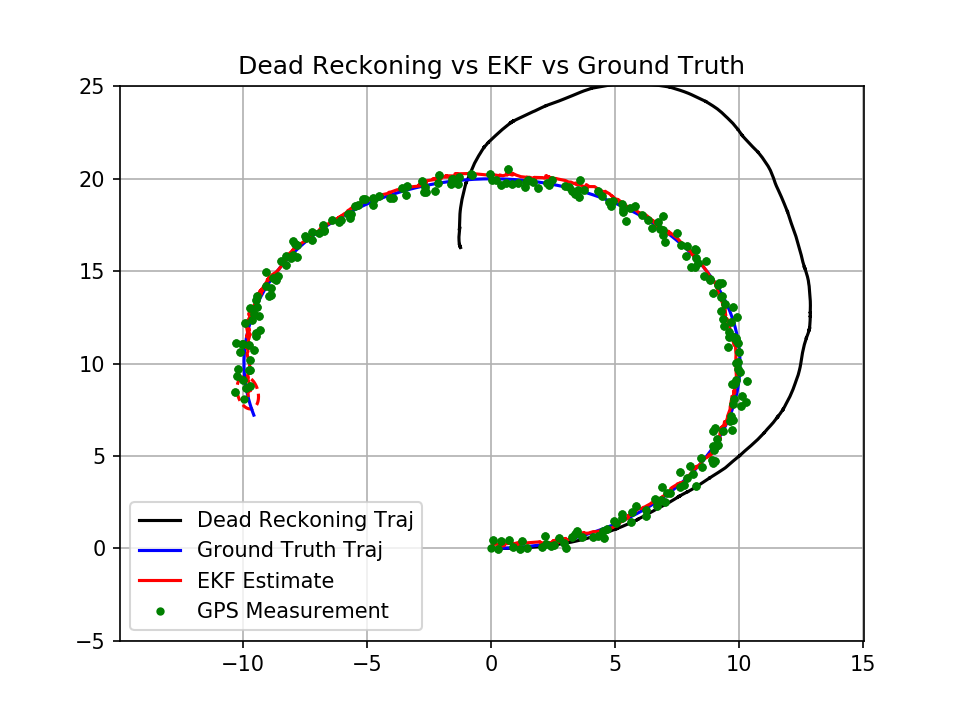

In [17]:
# Animate EKF
fig, ax = plt.subplots()
predData, = plt.plot([],[],'-k', label='Dead Reckoning Traj')
ellipseData, = plt.plot([],[],'--r')
gtData, = plt.plot([],[],'-b', label='Ground Truth Traj')
ekfData, = plt.plot([],[],'-r', label='EKF Estimate')
measData, = plt.plot([],[],'.g', label='GPS Measurement')
numFrames = 1000

frames=np.linspace(0, numFrames)
ind = [(int)(frame * allellipsesX.shape[0]/ numFrames) for frame in frames]
ind_GPS = [(int)(frame * allMeasurements.shape[0]/ numFrames) for frame in frames]

def init():
    x_true = hxTrue[0,:]
    y_true = hxTrue[1,:]
    ax.set_xlim([np.min(x_true) - 5, np.max(x_true) + 5])
    ax.set_ylim([np.min(y_true) - 5, np.max(y_true) + 5])
    plt.title("Dead Reckoning vs EKF vs Ground Truth")
    plt.legend()
    ax.grid(True)
    
def update(frameID):
    predData.set_data(hxDR[0,0:ind[frameID]], hxDR[1,0:ind[frameID]])
    gtData.set_data(hxTrue[0,0:ind[frameID]], hxTrue[1,0:ind[frameID]])
    ellipseData.set_data(allellipsesX[ind[frameID],:],allellipsesY[ind[frameID],:])
    ekfData.set_data(hxEst[0,0:ind[frameID]], hxEst[1,0:ind[frameID]])
    measData.set_data(allMeasurements[0:ind_GPS[frameID],0], allMeasurements[0:ind_GPS[frameID],1])

anim = FuncAnimation(fig, update, frames=numFrames, interval= 500, init_func=init, blit=True)
plt.show()